In [22]:
import numpy as np
import matplotlib.pyplot as plt

import utils.network as network_class
import utils.transformer_model as transformer_model_class
import utils.model_trainer as model_trainer_class
import utils.data_processer_transformer as data_processer_functions

import torch
import torch.nn as nn

from importlib import reload
from tqdm import trange
from pprint import pprint
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [23]:
print(torch.cuda.get_device_name(torch.cuda.current_device()))
print('CUDA Version', torch.version.cuda)
print('PyTorch Version', torch.__version__)

NVIDIA GeForce RTX 2080 Ti
CUDA Version 11.3
PyTorch Version 1.12.1


# Define Network 

### Define Network 

In [78]:
num_nodes = 5
num_edges = 5

adjacency_nodexedge = np.zeros([num_nodes, num_edges]) # node x edge adjacency matrix of the network (with all tunnels)
adjacency_nodexedge = np.array([[-1,0,0,0,0], # -1 => node is edge's source
                                [1,-1,-1,0,0], # 1 => node is edge's destination
                                [0,1,0,-1,0],
                                [0,0,1,1,-1],
                                [0,0,0,0,1]])
                                
num_tunnels = 2

is_edge_in_tunnel      = np.zeros([num_tunnels, num_edges, ])
external_arrival_rates = np.zeros([num_tunnels, num_nodes, ])
overlay_service_rates  = np.zeros([num_tunnels, num_edges, ])
underlay_service_rates = np.zeros([num_tunnels, num_edges, ])

# tunnel 0
is_edge_in_tunnel[0,:]      = np.array([1,1,0,1,1]) # 1 => edge is a part of the tunnel, 0 => otherwise
external_arrival_rates[0,:] = np.array([0.9,0,0,0,0])
overlay_service_rates[0,:]  = np.array([1,0,0,0,0])
underlay_service_rates[0,:] = np.array([0,1,0,1,1])

# tunnel 1
is_edge_in_tunnel[1,:]      = np.array([1,0,1,0,1]) # 1 => edge is a part of the tunnel, 0 => otherwise
external_arrival_rates[1,:] = np.array([0.9,0,0,0,0])
overlay_service_rates[1,:]  = np.array([1,0,0,0,0])
underlay_service_rates[1,:] = np.array([0,0,1,0,1])

### Get Network Class

In [79]:
reload(network_class)
my_network = network_class.Network(
    num_tunnels,
    num_nodes,
    num_edges,
    adjacency_nodexedge,
    is_edge_in_tunnel, 
    underlay_service_rates,
    external_arrival_rates)

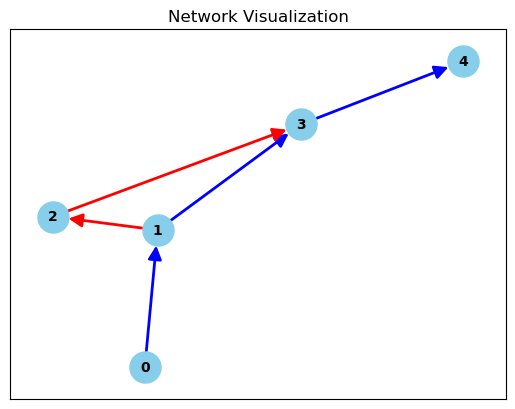

In [80]:
my_network.visualize(custom_seed = 8)

# Simulate Network

In [81]:
packets_in_flight, tunnel_backlogs, tunnel_injections, tunnel_exits = my_network.simulate(overlay_service_rates, total_time = 100000, custom_seed = 5)

# Model Training

In [104]:
def prepare_data(device, tunnel_backlogs, packets_in_flight, tunnel_injections, tunnel_exits, look_back):
    # class to split data, scale data, and rescale data
    data_processer = data_processer_functions.DataProcessor()

    # create time series sequences with given look_back hyperparameter
    packets_in_flight_all = data_processer.create_sequences(torch.Tensor(packets_in_flight), look_back).to(device)
    tunnel_injections_all = data_processer.create_sequences(torch.Tensor(tunnel_injections), look_back).to(device)
    tunnel_exits_all = data_processer.create_sequences(torch.Tensor(tunnel_exits), look_back).to(device)

    src_all = torch.concat((packets_in_flight_all, tunnel_injections_all), dim=-1)
    src_all = torch.concat((src_all, tunnel_exits_all), dim=-1)

    tgt_all = data_processer.create_sequences(torch.Tensor(tunnel_backlogs), look_back).to(device)

    # feature engineering
    # src_all = data_processer.feature_transform(device, src_all)

    # split into train and test
    src_train_unscaled, tgt_train_unscaled, \
        src_test_unscaled, tgt_test_unscaled = data_processer.split_train_test(src_all, tgt_all)

    # rescale to [0,1]
    src_train, tgt_train = data_processer.scale_train(src_train_unscaled, tgt_train_unscaled, is_x_sequenced = True)
    src_test, tgt_test = data_processer.scale_test(src_test_unscaled, tgt_test_unscaled)

    # decoder side of transformer will have inout and output
    tgt_train_input, tgt_train_output = data_processer.create_tgt_input_outputs(tgt_train)
    tgt_test_input, tgt_test_output = data_processer.create_tgt_input_outputs(tgt_test)

    return data_processer, src_train, tgt_train_input, tgt_train_output, src_test, tgt_test_input, tgt_test_output

In [120]:
def get_error_rates(transformer_predictor, src, y, data_processer):
    # get predictions
    transformer_predictor.eval()
    y_pred = transformer_predictor.evaluate(src)

    # rescale back to queue sizes
    _, y_pred_unscaled = data_processer.inverse_scale(x_scaled=0, y_scaled=y_pred)
    _, y_unscaled = data_processer.inverse_scale(x_scaled=0, y_scaled=y)
    y_pred_unscaled = np.round(y_pred_unscaled.cpu().numpy())
    y_unscaled = y_unscaled.cpu().numpy()

    # calculate root mean squared error, and max absolute percentage error
    rmse = mean_squared_error(y_unscaled, y_pred_unscaled, squared = False) # rms = np.sqrt(np.mean((Y_predicted-Y)**2))
    mape = mean_absolute_percentage_error(y_unscaled[y_unscaled>0], y_pred_unscaled[y_unscaled>0])*100 # mape = 100*np.mean(np.abs(y_pred_unscaled-y_unscaled)[y_unscaled>0]/y_unscaled[y_unscaled>0])

    error_rates = {'rmse': rmse, 'mape': mape}

    return error_rates, src, y_unscaled, y_pred_unscaled

In [ ]:
def plot_scatter_plot(x_in, y_in):
    plt.scatter(x_in[:, 1], x_in[:, 0], c = y_in, cmap='viridis', s=5, alpha=0.7)
    plt.xlabel('Number of flights in packet along tunnel 1')
    plt.ylabel('Number of flights in packet along tunnel 0')
    cbar = plt.colorbar()
    cbar.set_label('True total queue backlog in tunnel 0')
    plt.show()

In [121]:
# def train_model_and_get_performance(device, tunnel_backlogs, packets_in_flight, look_back, model_dim, num_heads, learning_rate):
    
#     # prepare data
#     data_processer, src_train, tgt_train_input, tgt_train_output, y_train, \
#         src_test, tgt_test_input, y_test = prepare_data(device, tunnel_backlogs, packets_in_flight, look_back)
    
#     # seeds for reproducibility
#     np.random.seed(0)
#     torch.manual_seed(0)

#     # define model with given hidden_sizes
#     src_size  = src_train.shape[-1]
#     tgt_size = tgt_train_input.shape[-1]
#     output_size = y_train.shape[-1]
#     num_encoder_layers = 3
#     num_decoder_layers = 3
#     dropout = 0.1
#     transformer_predictor = transformer_model_class.TransformerModel(src_size, tgt_size, model_dim, output_size, look_back, \
#                                                     num_heads, num_encoder_layers, num_decoder_layers, dropout, device).to(device)

#     num_epochs = 20
#     batch_size = 512

#     # define tools for training with given hyperparameters
#     trainer = model_trainer_class.modelTrainer(criterion = nn.MSELoss(), device = device)
#     optimizer = torch.optim.Adam(transformer_predictor.parameters(), lr = learning_rate)

#     # training loop
#     for epoch in range(num_epochs):
#         trainer.random_perm_indices = np.random.permutation(np.arange(src_train.shape[0]))
#         trainer.batch_start_index = 0
#         tot_iters = np.int16(src_train.shape[0]/batch_size)
#         pbar = trange(tot_iters)
#         for iter in pbar:
#             # get batch and perform a training epoch 
#             src_batch, tgt_batch_input, tgt_batch_output, y_batch = trainer.get_train_batch_transformer(src_train, tgt_train_input, tgt_train_output, y_train, batch_size)
#             loss_value = trainer.batch_step_transformer(transformer_predictor, src_batch, tgt_batch_input, tgt_batch_output, y_batch, optimizer) 
#             pbar.set_postfix({'epoch': f'{epoch+1}/{num_epochs}', 'iter':f'{iter+1}/{tot_iters}', 'loss': loss_value, 'look_back': src_train.shape[1], 'learning_rate': learning_rate})

#     test_error_rates, x_test, y, y_pred = get_error_rates(transformer_predictor, src_test, y_test, data_processer)

#     return transformer_predictor, test_error_rates

In [161]:
reload(data_processer_functions)
reload(transformer_model_class)
reload(model_trainer_class)

look_back = 10

# define model with given hidden_sizes
model_dim = 4
num_heads = 2
num_encoder_layers = 3
num_decoder_layers = 3
dropout = 0.1

learning_rate = 1e-3
num_epochs = 20
batch_size = 128

In [162]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# prepare data
data_processer, src_train, tgt_train_input, tgt_train_output, \
    src_test, tgt_test_input, tgt_test_output = prepare_data(device, tunnel_backlogs, packets_in_flight, tunnel_injections, tunnel_exits, look_back)

In [163]:
# seeds for reproducibility
np.random.seed(0)
torch.manual_seed(0)
src_size  = src_train.shape[-1]
tgt_size = tgt_train_input.shape[-1]
output_size = tgt_test_output.shape[-1]

transformer_predictor = transformer_model_class.TransformerModel(src_size, tgt_size, model_dim, output_size, look_back, \
                                                num_heads, num_encoder_layers, num_decoder_layers, dropout, device).to(device)

In [168]:
# define tools for training with given hyperparameters
trainer = model_trainer_class.modelTrainer(criterion = nn.MSELoss(), device = device)
optimizer = torch.optim.Adam(transformer_predictor.parameters(), lr = learning_rate)

# training loop
for epoch in range(num_epochs):
    trainer.random_perm_indices = np.random.permutation(np.arange(src_train.shape[0]))
    trainer.batch_start_index = 0
    tot_iters = np.int16(src_train.shape[0]/batch_size)
    pbar = trange(tot_iters)
    for iter in pbar:
        # get batch and perform a training epoch 
        src_batch, tgt_batch_input, tgt_batch_output, y_batch = trainer.get_train_batch_transformer(src_train, tgt_train_input, tgt_train_output, y_train, batch_size)
        loss_value = trainer.batch_step_transformer(transformer_predictor, src_batch, tgt_batch_input, tgt_batch_output, y_batch, optimizer) 
        pbar.set_postfix({'epoch': f'{epoch+1}/{num_epochs}', 'iter':f'{iter+1}/{tot_iters}', 'loss': loss_value, 'look_back': src_train.shape[1], 'learning_rate': learning_rate})

100%|██████████| 703/703 [00:19<00:00, 35.74it/s, epoch=20/20, iter=703/703, loss=0.000391, look_back=10, learning_rate=0.001]


In [169]:
y_test = tgt_test_output[:,-1,:]
test_error_rates, x_test, y, y_pred = get_error_rates(transformer_predictor, src_test, y_test, data_processer)
pprint(test_error_rates)

{'mape': 13.548500835895538, 'rmse': 10.057571}


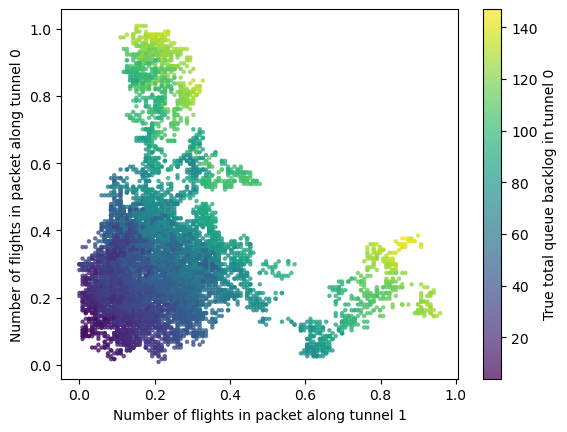

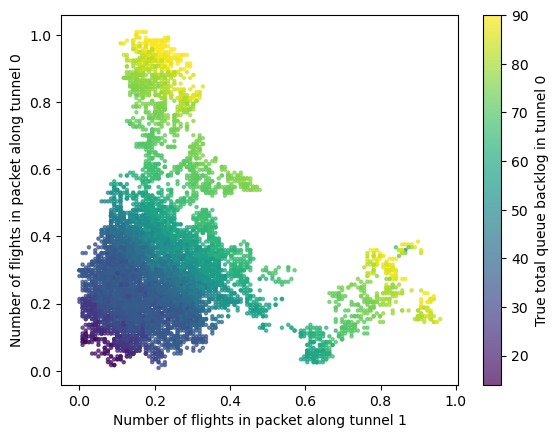

In [170]:
tt = -1
plot_scatter_plot(x_test[:,tt,:].cpu().numpy(), y[:,1])
plot_scatter_plot(x_test[:,tt,:].cpu().numpy(), y_pred[:,1])

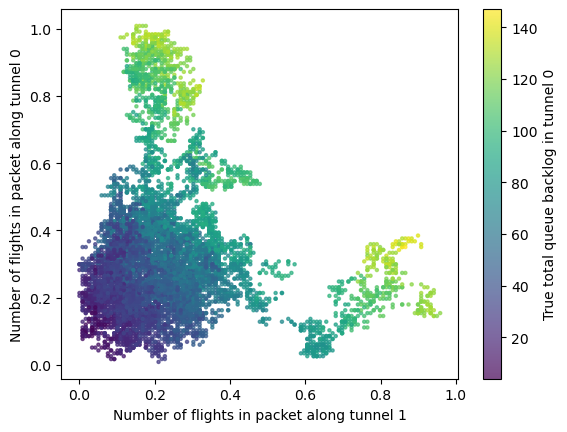

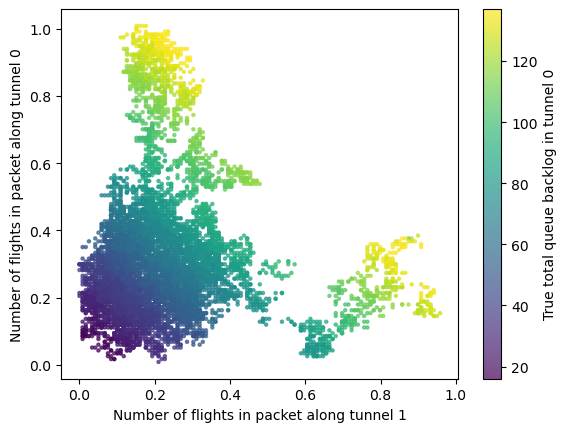

In [171]:
tt = -5
plot_scatter_plot(x_test[:,tt,:].cpu().numpy(), y[:,1])
plot_scatter_plot(x_test[:,tt,:].cpu().numpy(), y_pred[:,0])